Using device: cuda

Preparing EuroSAT dataset...
EuroSAT loaded: 21600 train, 5400 test images.

--- Evaluating BYOL Encoder ---
Training linear classifier...
  -> Epoch 1/15 - Test Accuracy: 77.72%
  -> Epoch 2/15 - Test Accuracy: 79.28%
  -> Epoch 3/15 - Test Accuracy: 78.91%
  -> Epoch 4/15 - Test Accuracy: 81.69%
  -> Epoch 5/15 - Test Accuracy: 76.69%
  -> Epoch 6/15 - Test Accuracy: 79.94%
  -> Epoch 7/15 - Test Accuracy: 81.22%
  -> Epoch 8/15 - Test Accuracy: 81.94%
  -> Epoch 9/15 - Test Accuracy: 80.93%
  -> Epoch 10/15 - Test Accuracy: 80.28%
  -> Epoch 11/15 - Test Accuracy: 82.91%
  -> Epoch 12/15 - Test Accuracy: 80.93%
  -> Epoch 13/15 - Test Accuracy: 82.06%
  -> Epoch 14/15 - Test Accuracy: 83.87%
  -> Epoch 15/15 - Test Accuracy: 84.39%

--- Detailed Report & Visuals for: BYOL ---
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.82      0.87      0.84       559
              Forest       0.98      0.93 

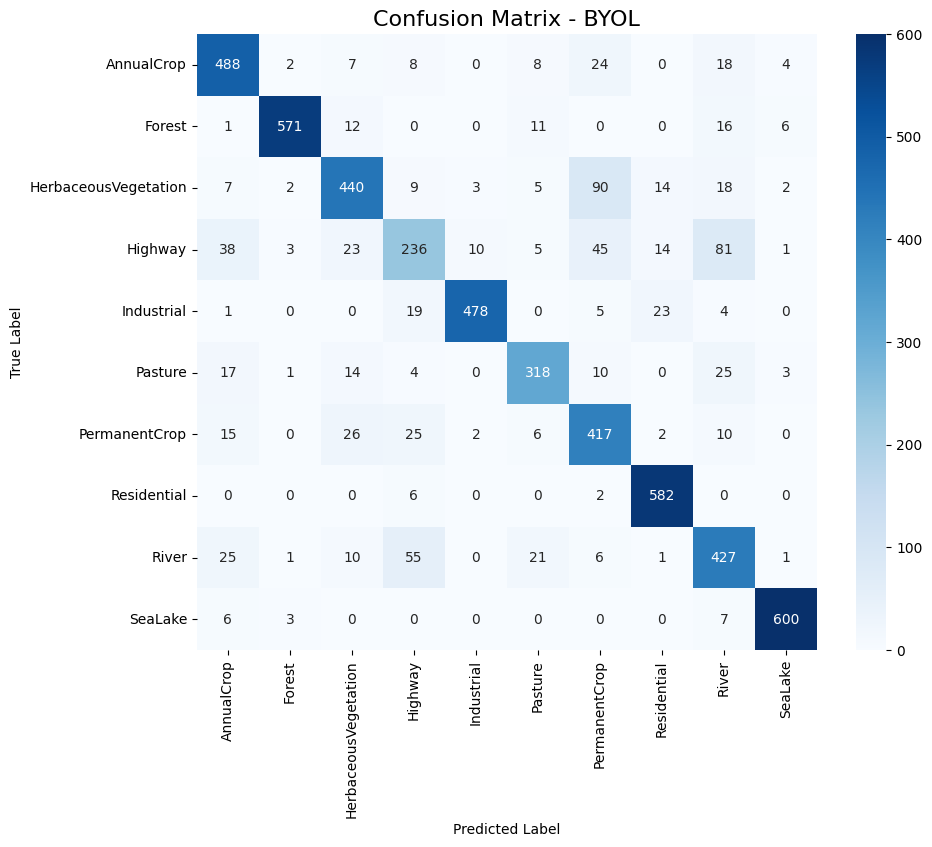

Extracting features for t-SNE:   0%|          | 0/22 [00:00<?, ?it/s]

Running t-SNE on 2000 samples...


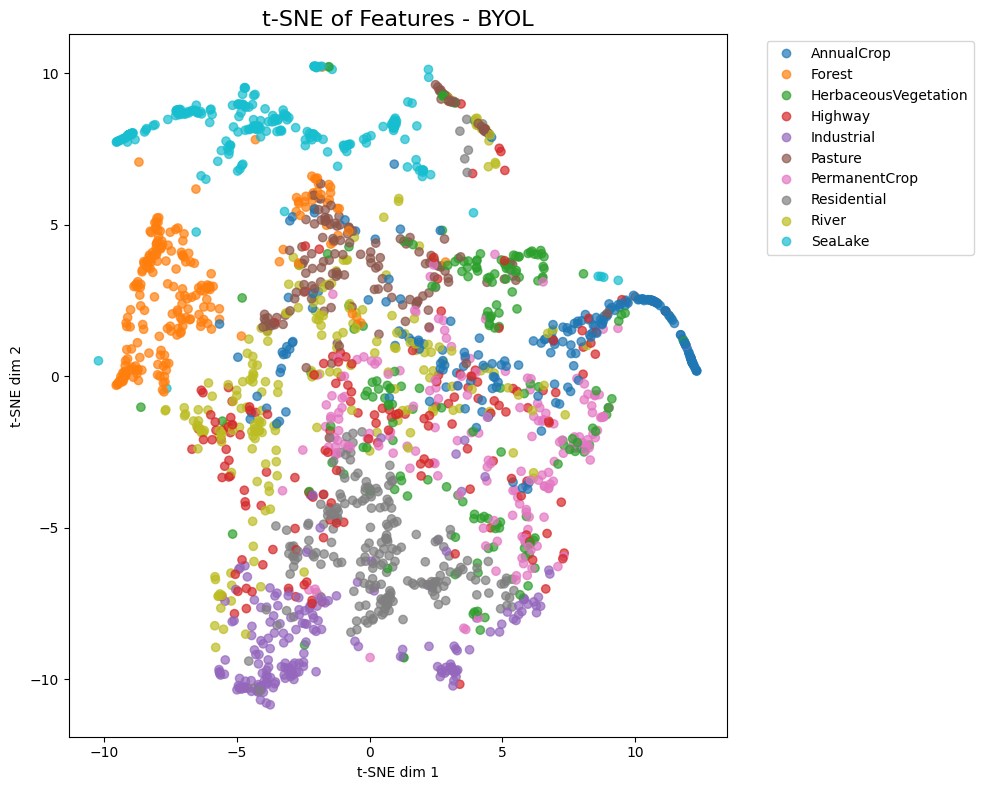


--- Evaluating Barlow Twins Encoder ---
Training linear classifier...
  -> Epoch 1/15 - Test Accuracy: 71.35%
  -> Epoch 2/15 - Test Accuracy: 72.85%
  -> Epoch 3/15 - Test Accuracy: 70.30%
  -> Epoch 4/15 - Test Accuracy: 73.50%
  -> Epoch 5/15 - Test Accuracy: 75.20%
  -> Epoch 6/15 - Test Accuracy: 74.67%
  -> Epoch 7/15 - Test Accuracy: 75.81%
  -> Epoch 8/15 - Test Accuracy: 75.17%
  -> Epoch 9/15 - Test Accuracy: 77.22%
  -> Epoch 10/15 - Test Accuracy: 74.59%
  -> Epoch 11/15 - Test Accuracy: 74.41%
  -> Epoch 12/15 - Test Accuracy: 77.20%
  -> Epoch 13/15 - Test Accuracy: 77.00%
  -> Epoch 14/15 - Test Accuracy: 76.22%
  -> Epoch 15/15 - Test Accuracy: 77.46%

--- Detailed Report & Visuals for: Barlow Twins ---
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.79      0.84      0.81       559
              Forest       0.87      0.91      0.89       617
HerbaceousVegetation       0.71      0.64      0.67       59

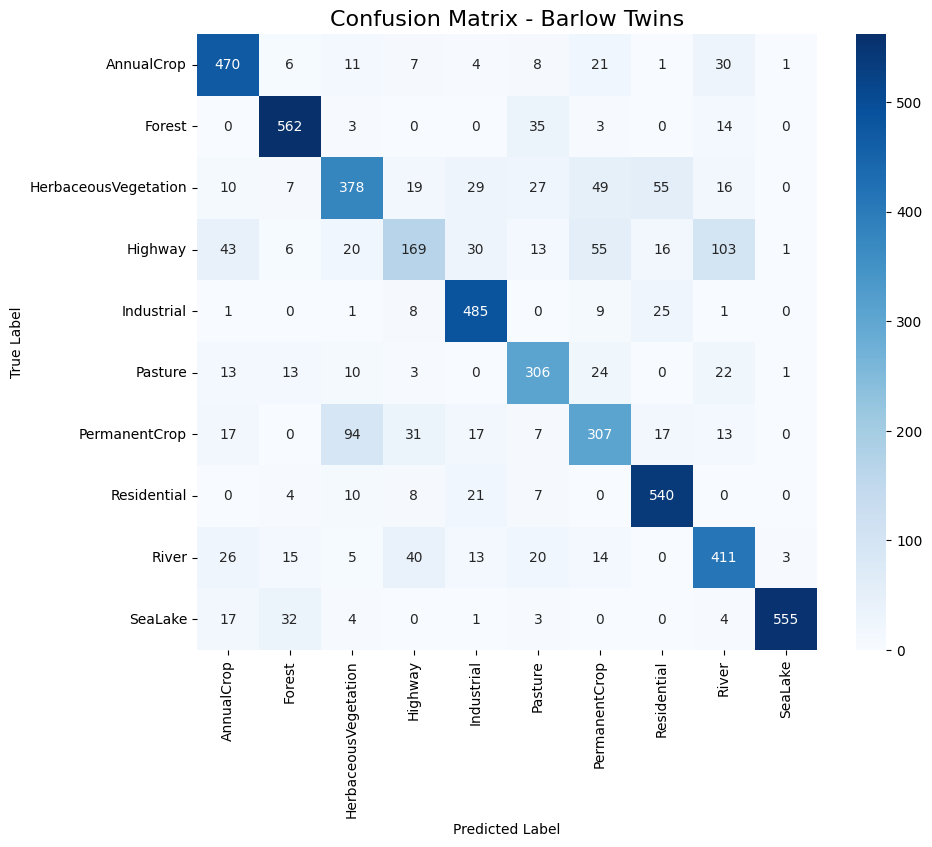

Extracting features for t-SNE:   0%|          | 0/22 [00:00<?, ?it/s]

Running t-SNE on 2000 samples...


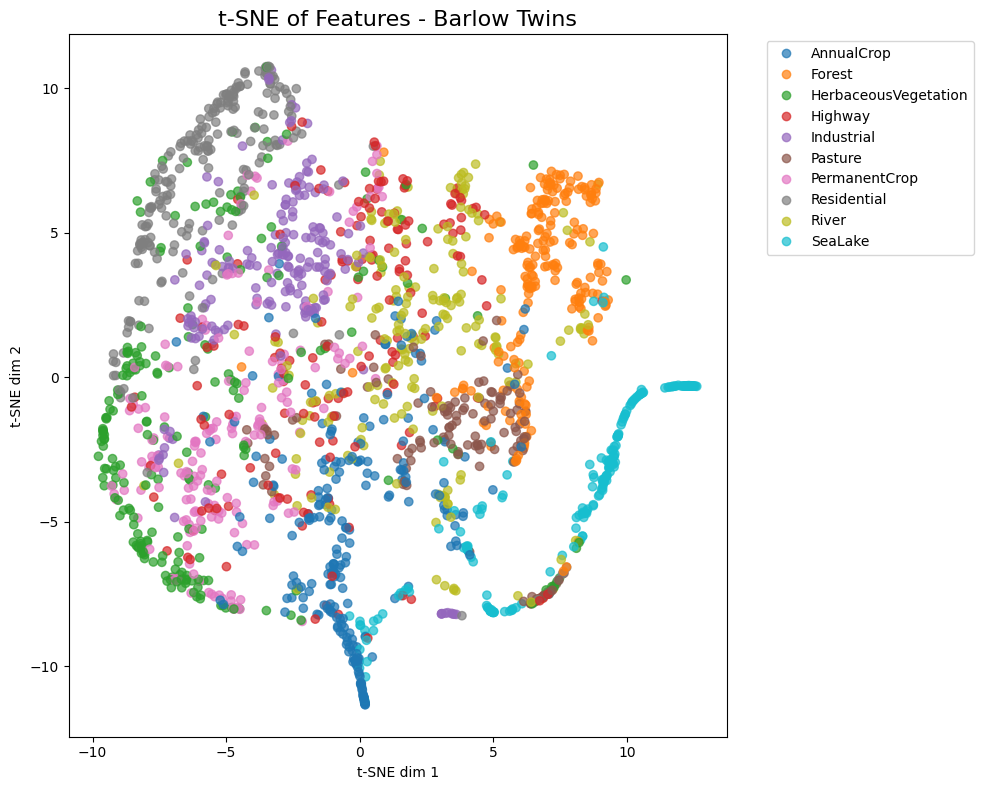


--- Evaluating Scratch (Baseline) Encoder ---
Training linear classifier...
  -> Epoch 1/15 - Test Accuracy: 57.98%
  -> Epoch 2/15 - Test Accuracy: 65.24%
  -> Epoch 3/15 - Test Accuracy: 68.04%
  -> Epoch 4/15 - Test Accuracy: 67.67%
  -> Epoch 5/15 - Test Accuracy: 68.96%
  -> Epoch 6/15 - Test Accuracy: 68.00%
  -> Epoch 7/15 - Test Accuracy: 71.44%
  -> Epoch 8/15 - Test Accuracy: 71.83%
  -> Epoch 9/15 - Test Accuracy: 69.39%
  -> Epoch 10/15 - Test Accuracy: 73.78%
  -> Epoch 11/15 - Test Accuracy: 70.39%
  -> Epoch 12/15 - Test Accuracy: 73.04%
  -> Epoch 13/15 - Test Accuracy: 73.09%
  -> Epoch 14/15 - Test Accuracy: 73.35%
  -> Epoch 15/15 - Test Accuracy: 72.00%

--- Detailed Report & Visuals for: Scratch (Baseline) ---
Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.91      0.50      0.64       559
              Forest       0.91      0.93      0.92       617
HerbaceousVegetation       0.53      0.79      0

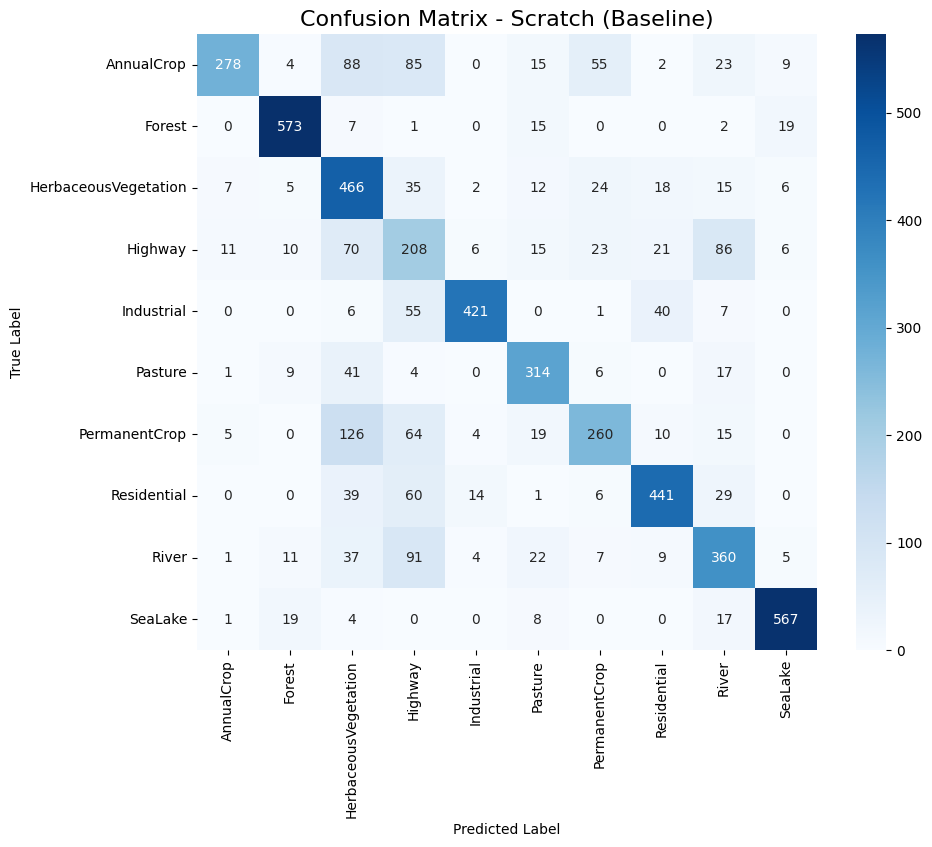

Extracting features for t-SNE:   0%|          | 0/22 [00:00<?, ?it/s]

Running t-SNE on 2000 samples...


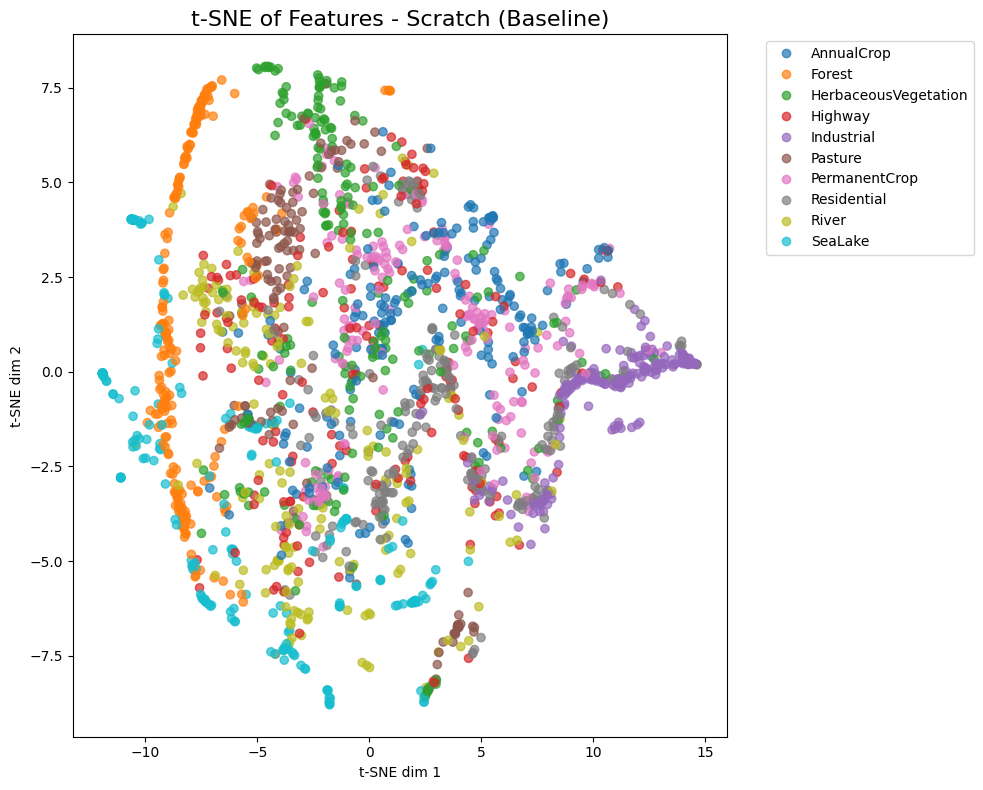



      FINAL ACCURACY RESULTS ON EUROSAT
BYOL                : 84.39% accuracy
Barlow Twins        : 77.46% accuracy
Scratch (Baseline)  : 72.00% accuracy


In [2]:
# ==============================================================================
# 05 - EVALUATION AND ANALYSIS 
# ==============================================================================
# Purpose: A comprehensive evaluation suite that includes:
#          1. Per-epoch accuracy during linear probing.
#          2. A detailed classification report (Precision, Recall, F1-Score).
#          3. A visual confusion matrix.
#          4. A t-SNE plot to visualize the quality of feature representations.
# ==============================================================================

# --- 0. Imports ---
!pip install "scikit-learn" "seaborn" -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets, torchvision.transforms as T, torchvision.models as models
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import os
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Configuration ---
CONFIG = {
    'byol_model_path': "/kaggle/input/03-byol-training-25pct/byol_best_encoder_25pct.pth",
    'barlow_model_path': "/kaggle/input/04-barlow-twins-training-25pct/barlow_best_encoder_25pct.pth",
    'eval_epochs': 15, 'eval_batch_size': 256, 'eval_lr': 0.01,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu', 'num_workers': 2,
}

# --- 2. EuroSAT Dataset ---
def get_eurosat_loaders(batch_size, num_workers):
    print("Preparing EuroSAT dataset..."); transform = T.Compose([T.Resize((224, 224)), T.ToTensor(), T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])
    full_dataset = datasets.EuroSAT(root='./', download=True, transform=transform)
    train_size=int(0.8*len(full_dataset)); test_size=len(full_dataset)-train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    print(f"EuroSAT loaded: {len(train_dataset)} train, {len(test_dataset)} test images.")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers); test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, test_loader, full_dataset.classes

# --- 3. Evaluation & Analysis Functions ---
def test_classifier(encoder, classifier, loader, device):
    encoder.eval(); classifier.eval(); all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            features = encoder(images); outputs = classifier(features); _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

def run_linear_probing(encoder, train_loader, test_loader, num_classes, device):
    for param in encoder.parameters(): param.requires_grad=False
    classifier = nn.Linear(512, num_classes).to(device)
    criterion = nn.CrossEntropyLoss(); optimizer = optim.Adam(classifier.parameters(), lr=CONFIG['eval_lr'])
    print("Training linear classifier...")
    for epoch in range(CONFIG['eval_epochs']):
        classifier.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad(): features = encoder(images)
            outputs = classifier(features); loss = criterion(outputs, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        epoch_acc = accuracy_score(*test_classifier(encoder, classifier, test_loader, device)) * 100
        print(f"  -> Epoch {epoch+1}/{CONFIG['eval_epochs']} - Test Accuracy: {epoch_acc:.2f}%")
    return test_classifier(encoder, classifier, test_loader, device)

def analyze_and_plot_results(model_name, encoder, y_true, y_pred, class_names, test_loader, device):
    print(f"\n--- Detailed Report & Visuals for: {model_name} ---")
    # 1. Classification Report
    print("Classification Report:"); print(classification_report(y_true, y_pred, target_names=class_names))
    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred); plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()
    # 3. t-SNE Plot
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Extracting features for t-SNE", leave=False):
            all_features.append(encoder(images.to(device)).cpu().numpy()); all_labels.append(labels.numpy())
    features_np = np.concatenate(all_features); labels_np = np.concatenate(all_labels)
    subset_size = min(2000, features_np.shape[0]); indices = np.random.choice(features_np.shape[0], subset_size, replace=False)
    print(f"Running t-SNE on {subset_size} samples..."); tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(features_np[indices]); plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels_np[indices], cmap='tab10', alpha=0.7)
    plt.title(f't-SNE of Features - {model_name}', fontsize=16); plt.xlabel("t-SNE dim 1"); plt.ylabel("t-SNE dim 2")
    plt.legend(handles=scatter.legend_elements(num=len(class_names))[0], labels=class_names, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(); plt.show()

# --- 4. Main Execution ---
device = torch.device(CONFIG['device']); print(f"Using device: {device}\n")
train_loader, test_loader, class_names = get_eurosat_loaders(CONFIG['eval_batch_size'], CONFIG['num_workers'])
final_results = {}

models_to_evaluate = {
    "BYOL": CONFIG.get('byol_model_path'),
    "Barlow Twins": CONFIG.get('barlow_model_path'),
    "Scratch (Baseline)": None
}

for name, path in models_to_evaluate.items():
    print("\n" + "="*60 + f"\n--- Evaluating {name} Encoder ---")
    encoder = models.resnet18(weights=None); encoder.fc = nn.Identity()
    if path and os.path.exists(path):
        encoder.load_state_dict(torch.load(path, map_location=device))
    elif path:
        print(f"Model file not found: {path}. Skipping."); final_results[name] = f"Not Found"; continue
    encoder.to(device)
    y_true, y_pred = run_linear_probing(encoder, train_loader, test_loader, len(class_names), device)
    analyze_and_plot_results(name, encoder, y_true, y_pred, class_names, test_loader, device)
    final_results[name] = accuracy_score(y_true, y_pred) * 100

# --- Final Summary Table ---
print("\n\n" + "="*60); print("      FINAL ACCURACY RESULTS ON EUROSAT"); print("="*60)
sorted_results = sorted(final_results.items(), key=lambda item: item[1] if isinstance(item[1], float) else -1, reverse=True)
for model_name, acc in sorted_results:
    if isinstance(acc, float): print(f"{model_name:<20}: {acc:.2f}% accuracy")
    else: print(f"{model_name:<20}: {acc}")
print("="*60)